# Exercise - Classify handwritten digits with k-NN

The goal of this exercise is to **build a k-NN classifier to recognize images from the MNIST data set using a Pipeline object.** 

The original data set has 70 thousand images, but it can be slow to train using all the images. For this reason, we will use a subset of the data set.

* 5,000 images to train the classifier
* 1,000 images to test it

### Nearest neighbors algorithm

The *KNeighborsClassifier* object from Scikit-learn implements several algorithms to find the k nearest neighbors to a given data point. **The simplest strategy is to compute the distance to every other data points from the training set and select the k closest ones.** This is called **brute-force search**.

Some algorithms don't need to compute the distance to every data points at runtime. However, they require to build a sort of index of the data set before running the algorithm, and this operation can be **computationally expensive** for large ones. In our case, the brute strategy is faster.

'knn = KNeighborsClassifier(n_neighbors=.... algorithm='brut')

To get the list of strategies implemented in Scikit-learn: [KNeighborsClassifier page](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

### Load the data

In [2]:
import numpy as np

with np.load('Course 4\mnist-6k.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    data = dict(npz_file.items())
    X = npz_file['data']
    y = npz_file['labels']

X = X.astype(np.float)

print('x:', X) # [6.28, 2.719, 1.]
print('y:', y) # [2, 3, 5]
#print(data['data'])
#print(data['labels'])

x: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y: [5 0 4 ... 8 6 9]


In [3]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=1000, random_state=0)
print('Train set:',X_tr.shape, y_tr.shape)
print('Test set:', X_te.shape, y_te.shape)

Train set: (5000, 784) (5000,)
Test set: (1000, 784) (1000,)


In [4]:
X.shape

(6000, 784)

In [5]:
y.shape

(6000,)

In [6]:
y

array([5, 0, 4, ..., 8, 6, 9])

In [7]:
import pandas as pd
pd.value_counts(y, normalize=True)

1    0.111833
7    0.108500
4    0.103833
3    0.101333
6    0.101333
9    0.100167
0    0.098667
2    0.096833
8    0.091833
5    0.085667
dtype: float64

### Check images

In [8]:
flat_img = X[2,:]
flat_img.shape

(784,)

In [9]:
# Reshape the image
img = flat_img.reshape(28, 28)

# Print shape
print('shape:', img.shape)

shape: (28, 28)


In [10]:
y[2]

4

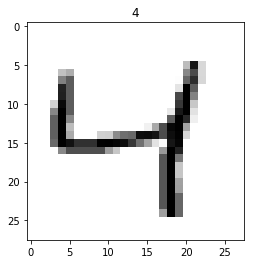

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(img,cmap=plt.cm.gray_r)
plt.title(y[2])
plt.show()

#### Baseline

In [12]:
from sklearn.dummy import DummyClassifier

# Create the dummy classifier
dummy = DummyClassifier(strategy='most_frequent')

In [13]:
# Fit it
dummy.fit(X_tr, y_tr)

# Compute test accuracy
accuracy = dummy.score(X_te,y_te)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.10


In [14]:
# "Most-frequent" predictions
y_pred_dummy = dummy.predict(X_te)
print('Predicted:', y_pred_dummy[:30], '..')
print('True labels:', y_te[:30], '..') 

Predicted: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] ..
True labels: [9 9 4 2 9 8 8 4 3 3 6 3 9 6 8 5 2 7 0 6 4 1 4 8 8 6 2 9 3 3] ..


### K-NN Classifier

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [16]:
# Create a k-NN pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5,algorithm='brute'))
])

# Fit estimator
knn_pipe.fit(X_tr, y_tr)

# Evaluate on test set
accuracy = knn_pipe.score(X_te, y_te)
print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.899


In [17]:
from sklearn.base import clone

knn_pipe2 = clone(knn_pipe)
knn_pipe2.set_params(scaler=None)
knn_pipe2.fit(X_tr, y_tr)
print('Accuracy: {:.3f}'.format(knn_pipe2.score(X_te, y_te)))

Accuracy: 0.941


In [18]:
knn_pipe.predict(X_tr)[:5]

array([1, 3, 8, 1, 1])

In [19]:
y_tr[:5]

array([1, 3, 8, 1, 1])

In [20]:
knn_pipe2.predict(X_tr)[:5]

array([1, 3, 8, 1, 1])

In [21]:
kn = KNeighborsClassifier(n_neighbors=5)
kn.fit(X_tr,y_tr)
kn.score(X_te, y_te)

0.941

### Tune K using grid search

In [22]:
k_values = np.r_[1,np.arange(2,20,2)]

In [26]:
results = []
for runs in range(10):
    
    X_tr, X_te,y_tr,y_te = train_test_split(X,y,test_size=1000, random_state=runs)
    
    for k in k_values:
        kn = KNeighborsClassifier(n_neighbors=k, algorithm='brute')
        kn.fit(X_tr, y_tr)
        results.append({
            'k':k,
            'runs':runs,
            'train accuracy':kn.score(X_tr, y_tr),
            'test accuracy':kn.score(X_te, y_te)
        })

In [27]:
results = pd.DataFrame(results)

In [28]:
results.head(10)

,k,runs,test accuracy,train accuracy
0,1,0,0.952,1.0000
1,2,0,0.943,0.9662
2,4,0,0.949,0.9642
3,6,0,0.941,0.9556
4,8,0,0.941,0.9514
5,10,0,0.941,0.9444
6,12,0,0.941,0.9416
7,14,0,0.937,0.9354
8,16,0,0.930,0.9328
9,18,0,0.931,0.9296


In [30]:
train_mean = results.groupby('k')['train accuracy'].mean()
test_mean = results.groupby('k')['test accuracy'].mean()
train_std = results.groupby('k')['train accuracy'].std()
test_std = results.groupby('k')['test accuracy'].std()

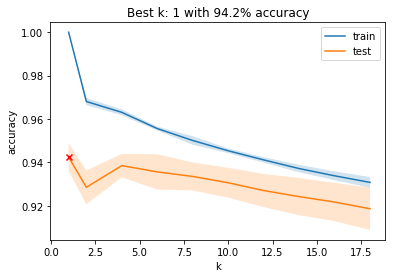

In [32]:
# Plot mean scores
plt.plot(k_values, train_mean, label='train')
plt.plot(k_values, test_mean, label='test')

# Add marker for best score
best_k = test_mean.idxmax()
plt.scatter(best_k, test_mean.max(), marker='x', c='red', zorder=10)

# Quantify variance with ±std curves
plt.fill_between(k_values, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(k_values, test_mean-test_std, test_mean+test_std, alpha=0.2)
plt.title('Best k: {} with {:.1f}% accuracy'.format(best_k, 100*test_mean[best_k]))
plt.ylabel('accuracy')
plt.xlabel('k')
plt.legend()
plt.show()

# Exercise - CIFAR-10 classification with k-NN

In the last exercise, we fitted a $k$-NN classifier to recognize images from the MNIST data set using raw pixel values and obtained reasonable results. **We will now try with the CIFAR-10 data set. This time, tuning the following parameters using grid search.**

* The number of neighbors
* The distance metric - L1 or L2 (Euclidean)
* The weighting function - uniform or by distance

We will start with a grid that only has a few k values to find the best distance metric and weighting function. Then we can fix these parameters and perform fine-tuning of the k value.

### Data description

The data set contains **32 by 32 color images from 10 different categories.** In total, there are 60,000 images, but we will use a subset of 6,000 images. The ten categories are numerically encoded with digits between 0 and 9.

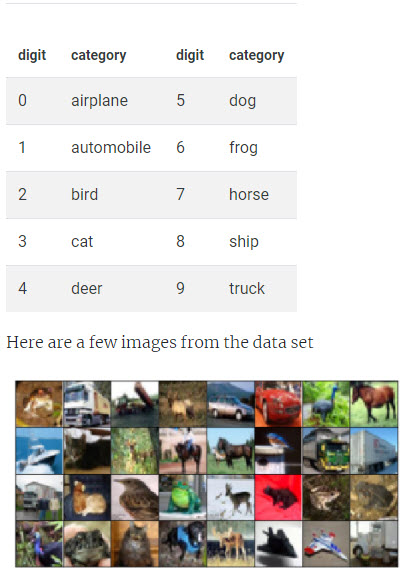

In [1]:
from IPython.display import Image
Image(filename='ImagesCIFAR.jpg')

The images are not standardized - they have different backgrounds and are taken from different angles and distances.

### Parallelized execution

**Processors can make multiple computations in parallel**. Scikit-learn $k$-NN implementation can leverage this to improve the speed of the classifier. The KNeighborsClassifier estimator provides an $n_jobs$ parameters for defining this number of parallel processes. We can set it to $-1$ to let Scikit-learn use all available processes.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Create k-NN classifier
KNeighborsClassifier(
    n_jobs=-1 # As many parallel jobs as possible
)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### load images

In [16]:
with np.load('Course 4\cifar10-6k.npz', allow_pickle=False) as npz_file:
    # Load the arrays
    X = npz_file['data']
    y = npz_file['labels']

print('x:', X) # [6.28, 2.719, 1.]
print('y:', y) # [2, 3, 5]

x: [[ 59  62  63 ... 123  92  72]
 [154 177 187 ... 143 133 144]
 [255 255 255 ...  80  86  84]
 ...
 [250 253 254 ... 240 233 229]
 [136 167 138 ...  31  82  35]
 [170 182 189 ...  92 109 118]]
y: [6 9 9 ... 9 4 8]


In [17]:
X.shape

(6000, 3072)

In [18]:
y.shape

(6000,)

In [19]:
X = X.astype(np.float)

In [20]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=1000, random_state=0)

In [21]:
import pandas as pd
pd.value_counts(y, normalize=True)

8    0.103333
2    0.103167
6    0.102667
9    0.102167
4    0.101833
0    0.101667
7    0.099500
5    0.097167
3    0.096667
1    0.091833
dtype: float64

### Check images

In [22]:
flat_img = X[5,:]

In [23]:
flat_img.shape

(3072,)

In [24]:
img = flat_img.reshape(32,32,3)

In [25]:
img.shape

(32, 32, 3)

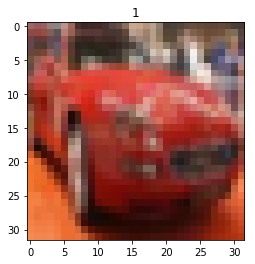

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(img/255)
plt.title(y[5])
plt.show()

### Baseline

In [27]:
from sklearn.dummy import DummyClassifier

In [28]:
dummy = DummyClassifier()

In [29]:
dummy.fit(X_tr,y_tr)

accuracy = dummy.score(X_te, y_te)
print('Accuracy:', accuracy)

Accuracy: 0.113


### k-NN classifier

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid

In [33]:
# Create Pipeline
knn_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('k_nn', KNeighborsClassifier(
        algorithm='brute',
        n_jobs=-1))
])

# Define values
k_values = np.arange(1,30,8)
weights = ['uniform','distance']
distances = [1,2]
print('k_values:',k_values)
print('weights:',weights)
print('distances:', distances)

# Create grid
grid = ParameterGrid({
    'k_nn__n_neighbors':k_values,
    'k_nn__weights':weights,
    'k_nn__p': distances
})
print('Combinations:', len(grid))

# Save accuracy on test set
results = []

# Run classifier
for params_dict in grid:
    knn_pipe.set_params(**params_dict)
    
    knn_pipe.fit(X_tr, y_tr)
    
    params_dict['accuracy'] = knn_pipe.score(X_te, y_te)
    
    results.append(params_dict)

k_values: [ 1  9 17 25]
weights: ['uniform', 'distance']
distances: [1, 2]
Combinations: 16


In [32]:
#knn_pipe.get_params() #if need to identify parameters

In [34]:
results_df = pd.DataFrame(results)

In [36]:
results_df.sort_values(by='accuracy', ascending=False)

,accuracy,k_nn__n_neighbors,k_nn__p,k_nn__weights
5,0.344,9,1,distance
13,0.325,25,1,distance
9,0.323,17,1,distance
4,0.322,9,1,uniform
8,0.312,17,1,uniform
12,0.308,25,1,uniform
0,0.298,1,1,uniform
1,0.298,1,1,distance
7,0.292,9,2,distance
11,0.290,17,2,distance


In [38]:
# Refine search and grid

# Create Pipeline
knn_pipe2 = Pipeline([
    ('scaler',StandardScaler()),
    ('k_nn', KNeighborsClassifier(
        weights='distance',
        algorithm='brute',
        p=1,
        n_jobs=-1))
])

# Create grid
grid2 = ParameterGrid({
    'k_nn__n_neighbors':np.arange(5,15,2)
})
print('Combinations:', len(grid2))

# Save accuracy on test set
results_refined = []

# Run classifier
for params_dict in grid2:
    knn_pipe2.set_params(**params_dict)
    
    knn_pipe2.fit(X_tr, y_tr)
    
    params_dict['accuracy'] = knn_pipe2.score(X_te, y_te)
    
    results_refined.append(params_dict)

Combinations: 5


In [39]:
results_refined_df = pd.DataFrame(results_refined)
results_refined_df.sort_values(by='accuracy', ascending=False)

,accuracy,k_nn__n_neighbors
2,0.344,9
3,0.333,11
1,0.332,7
4,0.324,13
0,0.318,5
